In [264]:
from __future__ import print_function
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import re
import sys
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Embedding, Dense, Dropout, GRU, LSTM, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers

In [243]:
BASE_DIR = './data'
GLOVE_DIR = os.path.join(BASE_DIR, 'glove.6B')
WEI_DIR = './weight'
skey = 'like'
item = 'microwave'

In [244]:
MAX_SEQUENCE_LENGTH = 32  # 每个文本或者句子的截断长度
MAX_NUM_WORDS = 20000  # 用于构建词向量的词汇表数量
EMBEDDING_DIM = 50  # 词向量维度
VALIDATION_SPLIT = 0.2

In [245]:
#"Indexing word vectors."
embeddings_index = {}
with open(os.path.join(GLOVE_DIR, 'glove.6B.50d.txt'), encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]  # 单词
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [246]:
texts = []  # 训练文本样本的list
labels_index = {}  # 标签和数字id的映射
labels = []  # 标签list

In [247]:
temp = pd.read_csv(item+'.csv')
temp = temp[['review_headline', 'review_body', 'like', 'tech']]
temp['review'] = temp['review_headline'] + '.' + temp['review_body']
temp = temp[['review', 'like', 'tech']]
temp['like'] +=1
train_num = np.sum(~pd.isna(temp['like']))

for index in temp.index:
    labels.append(temp.loc[index][skey])
    texts.append(str(temp.loc[index].review))

In [248]:
# 向量化文本样本
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
# fit_on_text(texts) 使用一系列文档来生成token词典，texts为list类，每个元素为一个文档。就是对文本单词进行去重后
tokenizer.fit_on_texts(texts)
# texts_to_sequences(texts) 将多个文档转换为word在词典中索引的向量形式,shape为[len(texts)，len(text)] -- (文档数，每条文档的长度)
sequences = tokenizer.texts_to_sequences(texts)


In [249]:
word_index = tokenizer.word_index  # word_index 一个dict，保存所有word对应的编号id，从1开始
print("Founnd %s unique tokens." % len(word_index)) 
# ['the', 'to', 'of', 'a', 'and', 'in', 'i', 'is', 'that', "'ax"] [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
print(list(word_index.keys())[0:10], list(word_index.values())[0:10])  #
 
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)  # 长度超过MAX_SEQUENCE_LENGTH则截断，不足则补0
labels = np.asarray(labels)
labels = to_categorical(labels[:train_num])
train_data = data[:train_num]
pre_data = data[train_num:]
print("训练数据大小为：", train_data.shape)
print("标签大小为:", labels.shape)


Founnd 6873 unique tokens.
['the', 'it', 'a', 'and', 'to', 'i', 'microwave', 'this', 'is', 'of'] [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
训练数据大小为： (303, 32)
标签大小为: (303, 3)


In [250]:
indices = np.arange(train_data.shape[0])
np.random.shuffle(indices)  # 打乱数据
train_data = train_data[indices]
labels = labels[indices]

In [251]:
num_validation_samples = int(VALIDATION_SPLIT * train_data.shape[0])
x_train = train_data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]

x_val = train_data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

In [252]:
# 准备词向量矩阵
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)  # 词汇表数量
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))  # 20000*100

In [253]:
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:  # 过滤掉根据频数排序后排20000以后的词
        continue
    embedding_vector = embeddings_index.get(word)  # 根据词向量字典获取该单词对应的词向量
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [271]:
embedding_layer = Embedding(input_dim=num_words,  # 词汇表单词数量
                            output_dim=EMBEDDING_DIM,  # 词向量维度
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,  # 文本或者句子截断长度
                            trainable=False)  # 词向量矩阵不进行训练

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')  # 返回一个张量，长度为1000，也就是模型的输入为batch_size*1000
embedded_sequences = embedding_layer(sequence_input)  # 返回batch_size*1000*100
x = Bidirectional(LSTM(2, kernel_initializer='orthogonal', 
                     activity_regularizer=regularizers.l2(0.05))
               )(embedded_sequences)
preds = Dense(labels.shape[1], activation='softmax', kernel_initializer='orthogonal')(x)
 
model = Model(sequence_input, preds)
early_stopping = EarlyStopping(monitor='val_acc', patience=8, verbose=2)
checkpoint = ModelCheckpoint(os.path.join(WEI_DIR, 'hair_dryer2.hdf5'),
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=[tf.keras.metrics.categorical_accuracy])
 
history = model.fit(x_train, y_train, batch_size=32, epochs=100,
          validation_data=(x_val, y_val), callbacks=[early_stopping, checkpoint])

Train on 243 samples, validate on 60 samples
Epoch 1/100
243/243 [==============================] - 4s 15ms/sample - loss: 1.0736 - categorical_accuracy: 0.4527 - val_loss: 1.0725 - val_categorical_accuracy: 0.5333
Epoch 2/100
243/243 [==============================] - 0s 462us/sample - loss: 1.0584 - categorical_accuracy: 0.5432 - val_loss: 1.0552 - val_categorical_accuracy: 0.5500
Epoch 3/100
243/243 [==============================] - 0s 357us/sample - loss: 1.0459 - categorical_accuracy: 0.5761 - val_loss: 1.0401 - val_categorical_accuracy: 0.5833
Epoch 4/100
243/243 [==============================] - 0s 320us/sample - loss: 1.0354 - categorical_accuracy: 0.5802 - val_loss: 1.0292 - val_categorical_accuracy: 0.6000
Epoch 5/100
243/243 [==============================] - 0s 345us/sample - loss: 1.0273 - categorical_accuracy: 0.5761 - val_loss: 1.0205 - val_categorical_accuracy: 0.6000
Epoch 6/100
243/243 [==============================] - 0s 345us/sample - loss: 1.0194 - categorical_a

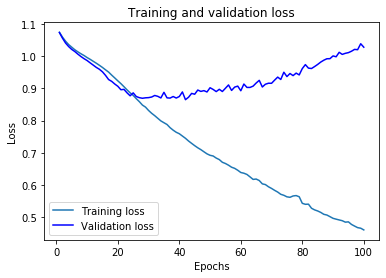

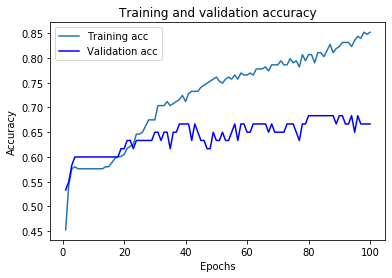

In [272]:
plt.clf()   # clear figure
history_dict = history.history
acc_values = history_dict['loss']
val_acc_values = history_dict['val_loss']
epochs = len(val_acc_values)
plt.plot(range(1, epochs+1), acc_values, label='Training loss')
plt.plot(range(1, epochs+1), val_acc_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(item+'_'+skey+'_1.jpg')

plt.figure()   # clear figure
acc_values = history_dict['categorical_accuracy']
val_acc_values = history_dict['val_categorical_accuracy']
plt.plot(range(1, epochs+1), acc_values, label='Training acc')
plt.plot(range(1, epochs+1), val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(item+'_'+skey+'_2.jpg')

plt.show()

In [273]:
y_pred = model.predict(pre_data)

In [274]:
pd.DataFrame(np.argmax(y_pred,axis=1)-1).to_csv(item+'_'+skey+'.csv', index=0, header=0)

array([0, 1, 1, ..., 1, 1, 1], dtype=int64)